# Report on Personal Coding Experience in F&B company industry attachment project
## by Lin Yixiu

The purpose of this notebook to showcase a notable coding project I have taken on in the past involving an F&B company.

## Vending machine scheduling algorithm for a F&B company

### Introduction

This is an industry-attachment project I have taken on recently as part of a team of 5 in a course on business analytics in my university.

The client company is a F&B company which has many vending machines all around Singapore that has to be visited regularly by the servicemen working under it. The duty of the servicemen is to top up and collect the money inside the vending machines. The client already has grouped the vending machines into different clusters and had one serviceman to be responsible for each cluster. 

The objectives of the project for my team was to identify any part of this operation that can be optimised using data-driven methods.

For my part of the project, I created an algorithm that generates schedules for servicemen to follow when topping up the vending machines. Before the project, the servicemen were only given the cluster or list of vending machines to go on. They have to plan which vending machines they have to visit each day. Having an algorithm that generates a schedule reduces the mental effort servicemen need to take to conduct their operations.

### Steps to generate the scheduling algorithm 

The client gave us some specifications for the schedule. For starters, the client categorised the vending machines based on the monthly sales it generates as well into 'High Sales', 'Moderate Sales' and 'Low Sales'.

The serviceman has to visit each machine a different number of times each month depending on the level of sales it generates each month.

The client has posed some constraints on the workload of each serviceman on each working day in terms of the number of machines they can visit and the amount of time they can spend visiting the machines each day.

After much discussion, the team and I decided that it would be best if the algorithm created a repeatable monthly schedule. We have also created a location tag for each machine based on the type of location the machine is in. For instance, machines in schools will be tagged as 'School', those in remote areas will be tagged as 'Remote Area'. This is important for the schedule to consider as the location each machine is in affects the ease which it can be accessed at different periods of the day. 

It is also assumed that it takes different multiples of 15 minutes to top up each high-sales, moderate-sales and low-sales vending machine. This assumption comes after the team went on a shadowing experience with a serviceman during which we followed the serviceman around as he went about topping up the machines in a certain location.

It also further assumes that on any working day, it takes a 2 hours leeway for the servicemen to drive around the route. The reason for this assumption is that each cluster is quite constrained within a section of Singapore and it <a href='https://medium.com/@wirelessed/15-places-to-go-for-a-road-trip-in-singapore-697d6ec6eb3e#:~:text=The%20Road%20Trip%20Route&text=This%20round%20trip%20around%20Singapore,Dam%2C%20Changi%20Village%20and%20more.'> takes 4 hours to drive through the whole of Singapore</a>, so 2 hours is a reasonable assumption. This 2 hours is subtracted from the max amount of time the servicemen can spend visiting the machines each day to make the amount of time they can spend physically at those machines each day.

I initially attempted to use R to create the algorithm.

The algorithm goes through these few steps to create a schedule:
 - The algorithm firstly reads the Excel file with all the vending machine information in one cluster of machines (one serviceman is responsible for one cluster).
 - It will then initialise an empty list for the machines to be visited in the first day.
 - Order the machines in the cluster based on the location tag. The rationale for this is so that those in 'City Centres' or 'School' are visited first each day.
 - Slot the machines one by one into the list of machines.
 - If the max number of machines or the max duration of time the serviceman can spend topping up the machines is reached, create a new list and slot the next machine in that list.
 
The code is as below. Note that this is a Python notebook so the code is not runnable.

In [ ]:
# install necessary packages needed for use in R
install.packages('openxlsx2')
install.packages('dplyr')
install.packages('lubridate')
install.packages('readxl')
install.packages('writexl')

# Load necessary packages
library(openxlsx2)
library(dplyr)
library(lubridate)
library(readxl)
library(writexl)

#User inputs file path
filepath = readline(prompt="Please enter the entire directory path of the EXCEL FILE with information on the vending machines:")

# User picks a route
route_number = readline(prompt = "Enter a route number. No other input will be accepted: ")
if (nchar(route_number) == 3){
print(paste("Generating the schedule for route", route_number, "..."))}

# Load the Excel workbook
length_of_filepath <- nchar(filepath)
wb <- read_excel(substring(filepath, 2, length_of_filepath-1), sheet=route_number)
wb <- wb[1:16]

#set some scheduling constants
n_days_pmonth = 30
n_days_pweek = 7

# Define the number of times each machine should be visited per month
high_sales_freq <- 8
moderate_sales_freq <- 6
low_sales_freq <- 4

# Define the time required to top up machines of different sales categories
high_sales_time <- 45
moderate_sales_time <- 30
low_sales_time <- 15

# Define the maximum number of machines a serviceman can take per day
max_machines_per_day <- 15

#Define the amount of hours a serviceman spends on the road per day
ave_hours_spent_on_road <- 2

# Define the maximum number of hours a serviceman can do top-up per day
max_hours_per_day <- 8 - ave_hours_spent_on_road

# Define the order in which machines should be visited based on their location tags
location_order <- c("City Centre", "City Centre, Hard to access from parking space", "School", "City Centre, School", 
                    "School, Hard to access from parking space", "","Hard to access from parking space", "Remote Area", 
                    "Remote Area, Hard to access from parking space","Remote Area, School","Remote Area, Requires Escort", 
                    "Requires Escort")

# Create a function to calculate the time required to top up a set of machines
calculate_time <- function(machines) {
  high_sales <- machines$`Sales Category` == "HIGH SALES"
  moderate_sales <- machines$`Sales Category` == "MODERATE SALES"
  low_sales <- machines$`Sales Category` == "LOW SALES"
  time <- sum(high_sales * high_sales_time + 
                moderate_sales * moderate_sales_time + 
                low_sales * low_sales_time)
  return(time)
}

# Create a function to create a daily schedule for a serviceman
create_daily_schedule <- function(list_of_machines, max_machines, max_hours) {
  # Order the machines by location tag
  list_of_machines <- list_of_machines[order(match(list_of_machines$`Accessibility tag`, location_order)), ]
  # Initialize the variables
  schedule <- list()
  current_machines <- list()
  current_time <- 0
  # Visit the machines in the order of their location tag
  for (i in 1:nrow(list_of_machines)) {
    machine <- list_of_machines[i, ]
    # Check if the serviceman can still take more machines
    if (length(current_machines) < max_machines) {
      # Check if the serviceman has enough time left to top up the machine
      if (current_time + calculate_time(machine) <= max_hours * 60) {
        # Add the machine to the current set of machines and update the current time
        current_machines[[length(current_machines) + 1]] <- machine
        current_time <- current_time + calculate_time(machine)
      } else {
        # If the serviceman does not have enough time, move to the next day
        schedule[[length(schedule) + 1]] <- current_machines
        current_machines <- list()
        current_machines[[1]] <- machine
        current_time <- calculate_time(machine)
      }
    } else {
      # If the serviceman cannot take more machines, move to the next day
      schedule[[length(schedule) + 1]] <- current_machines
      current_machines <- list()
      current_machines[[1]] <- machine
      current_time <- calculate_time(machine)
    }
  }
  # Add the remaining machines to the last day of the schedule
  if (length(current_machines) > 0) {
    schedule[[length(schedule) + 1]] <- current_machines
  }
  return(schedule)
}

schedule <- create_daily_schedule(wb,max_machines_per_day,max_hours_per_day)

#change all daily schedules of the week into dataframes
for (i in 1:length(schedule)){
  schedule[[i]] <- dplyr::bind_rows(schedule[[i]])
}

for (i in 1:length(schedule)){
  schedule[[i]] <- as.data.frame(schedule[[i]])
}

### Issues with R algorithm

There are, however, a few issues with this algorithm. For starters, it only slots in the machines heuristically and does not try to optimise any part of the schedule in terms of an optimal number of machines that should be visited on each of the days. The algorithm also does not attempt to match the frequency which each machine should be visited based on its sales category. The algorithm could also only generate a 7-day schedule due to an inexplicable error. Any attempt to scale it to a full month will break the algorithm. Thus, I decided to turn to another approach.

### Second attempt using Python PuLP

In this new approach, I utilised this Python library called PuLP which is a linear program solver. A **linear program** is a mathematical way to translate an optimisation problem subject to certain constraints into mathematical terms and then solving the mathematical problem using a method called **linear optimisation**.

With the linear program solver, I attempted to minimise the difference between the number of vending machines visited by servicemen on each of the days of the working month. Simply put, that is having the number of machines visited on each day to be as equal as possible. The reason for this is to avoid situations when a serviceman will only visit one or two machines in a particular day. That will be a waste of fuel costs for the company as those few vending machines could be shifted to other days in the schedule.

To solve the issue surrounding having to visit each machine at certain frequencies, the first part of this algorithm involve duplicating each row of Excel data given (corresponding to one vending machine) based on its sales category. In thie code snippet below, the rows of data corresponding to vending machines with high sales, moderate sales and low sales are duplicated 8, 4 and 2 times respectively.

In [ ]:
# state the frequency per month which each category of sales should be visited. 
# This frequency can be changed by changing the number assigned to each of low_freq, mod_freq and high_freq if necessary.
low_freq = 2
mod_freq = 4
high_freq = 8

# Remove rows with 'Sales index' 0 as those machines are out of commission
index_to_drop = []
for i in df.index:
    if df.loc[i, 'Sales index'] == 0:
        index_to_drop.append(i)

df['Accessibility tag'] = df['Accessibility tag'].fillna('NA')

df = df.drop(index_to_drop)

# Define the duplication count for each sales index value
duplication_count = {3: 8, 2: 4, 1: 2}

# Create an empty dataframe to store the duplicated rows
duplicated_df = pd.DataFrame()

# Iterate through the rows of the original dataframe
for index, row in df.iterrows():
    # Get the duplication count for the current row based on its 'Sales index' value
    count = duplication_count[row['Sales index']]
    # Duplicate the current row and append the duplicates to the empty dataframe
    duplicates = pd.DataFrame([row] * count)
    duplicated_df = pd.concat([duplicated_df, duplicates])

# Reset the index of the duplicated dataframe
duplicated_df.reset_index(drop=True, inplace=True)

df = duplicated_df

After that, I coded out the the linear program I want PuLP to solve.

In greater detail, the linear program involves solving the value of a binary variable x<sub>ij</sub>. That binary variable represents whether a vending machine is visited on a particular day as a variable. In the solution, if machine i is visited on a particular day j, that variable representing that situation, x<sub>ij</sub>, will be given a value 1. Otherwise, the binary variable will give a value 0.

As mentioned, I will want to minimise the difference between the number of vending machines visited by servicemen on each of the days of the working month. As such, I coded out the objective function of the linear program (the mathematical expression to be optimised in the linear program) to be as such:
 - Divide the total number of machines in a cluster by the no. of working days in a month. For the sake of simplicity, that number of working days is taken to be 25 for every month. That number after division is the average number of machines to be visited each day. 
 - The difference between the sum of x<sub>ij</sub> and that average number of machines to be visited in a day for a particular day is then taken.
 - The mathematical expression or objective function to be minimised is thus the sum of all the differences across all 25 working days of the month.

With the objective function, I have also added a few constraints to the linear program to reflect some steps to improve the efficiency of their operations:
 - One such constraint is that there are at least 2.5 hours worth of vending machines that are in 'City Centre' or 'School' every working day. The purpose of this is to force at least a few of those vending machines to have to be visited every working day and so they could be cleared in the early morning hours if the servicemen choose to do so.
 - Another constraint whereby the visits of each particular vending machine is evenly spaced out within the month. This is done by considering the number of visits a vending machine of a certain sales category should be visited in a week. For e.g., high sales vending machines should be visited 8 times in a month. Given a 25-day schedule or 5 weeks, each high-sales vending machine will be visited 8/5 = 1.6 times on avg in a week. In real-world context, that means visiting a high-sales vending machine 1 or 2 times every week. Similarly, a moderate-sales vending machine and a low-sales vending machine is visited 0 or 1 times every week.
 
After considering all the constraints, the line 'prob.solve()' in this section of the algorithm then solves the optimisation problem. The cell right after 'prob.solve()' simply processes the output even more by pushing the days out of the 25 days which are assigned no machines to the back of the schedule.

In [ ]:
machines = df.index.tolist()
days = list(range(1, 26))

# set some known values
max_machines_p_day = 15
max_hours_p_day = 6
early_morning_hours = 2.5
max_min_p_day = max_hours_p_day * 60
early_morning_min_p_day = early_morning_hours * 60

# Set decision variables
x = pulp.LpVariable.dicts('x', [(m, d) for m in machines for d in days], lowBound = 0, upBound = 1, cat=pulp.LpBinary)

# Define the optimization problem
prob = pulp.LpProblem('Vending_Machine_Scheduling', pulp.LpMinimize)

avg_machines_p_day = len(df.index)/len(days)

# Define the objective function: the no of machines that are visited each day should be as close to 
# the average number of machines visited each day
# prob += pulp.lpSum([x[m, d] for m in machines for d in days])
prob += pulp.lpSum([pulp.lpSum([x[m, d] for m in machines]) - avg_machines_p_day for d in days 
                    if pulp.lpSum([x[m, d] for m in machines]) >= avg_machines_p_day for d in days])
prob += pulp.lpSum([avg_machines_p_day - pulp.lpSum([x[m, d] for m in machines]) for d in days 
                    if pulp.lpSum([x[m, d] for m in machines]) <= avg_machines_p_day for d in days])

# Define constraints
for d in days:
    
    # Total time spent on each day should not exceed 6 hours
    prob += pulp.lpSum([x[m, d] * df.at[m, 'Sales index']*15 for m in machines]) <= max_min_p_day
    
    # Maximum number of machines that can be visited in a day is 15
    prob += pulp.lpSum([x[m, d] for m in machines]) <= max_machines_p_day

    # For two-and-a-half hours of each day, City Centre or School machines are visited
    early_morning_machines = df.index[df["Accessibility tag"].isin(["City Centre", "School", 
                                                                    "City Centre, Hard to access from parking space", 
                                                                    "City Centre, School", 
                                                                    "School, Hard to access from parking space"]) 
                                      == True].tolist()
    prob += pulp.lpSum([df.at[m, 'Sales index']*15 * x[m, d] for m in early_morning_machines]) <= early_morning_min_p_day

for m in machines:
    # Each row of duplicated vending machine information must be in the schedule only once
    prob += pulp.lpSum([x[m, d] for d in days]) == 1

for n in range(1, int(len(days)/5+1)):
    for o in df["Outlet Code"].unique():
        # If a machine generates high sales, the machine should only be visited once to twice weekly.
        # with the machine visited 8 times in total a month.
        prob += math.floor(high_freq/(len(days)/5)) <= pulp.lpSum([x[m, w*n] for w in range(1, 6) for m in machines 
                                                                   if df.loc[m, 'Sales index'] 
                                                                   == 3 and df.loc[m, 'Outlet Code'] == o]) 
        <= math.ceil(high_freq/(len(days)/5))

        # If the machine generates low sales, the machine should only be visited none or once weekly.
        # with the machines visited 2 times in total a month
        prob += math.floor(mod_freq/(len(days)/5)) <= pulp.lpSum([x[m, w*n] for w in range(1, 6) for m in machines 
                                                                  if df.loc[m, 'Sales index'] 
                                                                  == 2 and df.loc[m, 'Outlet Code'] == o]) 
        <= math.ceil(mod_freq/(len(days)/5))
            
        # If the machine generates moderate sales, the machine should only be visited none or once weekly.
        # with the machines visited 4 times in total a month
        prob += math.floor(low_freq/(len(days)/5)) <= pulp.lpSum([x[m, w*n] for w in range(1, 6) for m in machines 
                                                                  if df.loc[m, 'Sales index'] 
                                                                  == 1 and df.loc[m, 'Outlet Code'] == o]) 
        <= math.ceil(mod_freq/(len(days)/5))
                
# Solve the optimisation problem
prob.solve()

In [ ]:
solution = dict([(m, d), x[m, d].value()] for m in machines for d in days)

days_w_no_machines = []

# Note down days where there are no machines are assigned by the code
for d in days:
    if sum([x[m, d].value() for m in machines]) == 0:
        days_w_no_machines.append(d)

# For each empty day
# shift the schedule of each day after that empty day forward to cover that empty day
# so that there aren't any days with blanks in the schedule which might be confusing
for day in days_w_no_machines:
    for d in days:
        if (day <= d <= len(days) - 1):
            for m in machines:
                solution[(m, d)] = solution[(m, d + 1)]

# Note that the last few days of the schedule should be empty
# since we are shifting the schedule of days forward to cover the empty day
for i in range(len(days_w_no_machines)):
    for m in machines:
        solution[(m, len(days) - i)] = 0.0

After solving the problem, the schedule can then be displayed. This can be done by finding which x<sub>ij</sub> on a certain day j has the value 1 and then displaying only those machines for the schedule for that day. 

The following code snippet displays how I have the algorithm display an overview of the machines to be visited each day. The cell after that then writes the schedule into an Excel file. As the schedule contains sensitive information, only portions of the output will be displayed.

In [ ]:
# Print the schedule overview
for d in days:
    if sum([solution[(m, d)] for m in machines]) != 0:
        list_machines_on_day_d = []
        for m in machines:
            if solution[(m, d)] == 1:
                list_machines_on_day_d.append(m)
        list_machines_on_day_d.sort(key = lambda x: df.at[x, 'PD Code'])
        print(f"Day {d}:{len(list_machines_on_day_d)} machines")
        for m in list_machines_on_day_d:
            print(f"- Vending machine Address:{df.at[m, 'Outlet Address']} S{df.at[m, 'PD Code']}" + 
                  f"(Sales Category: {df.at[m, 'Sales Category']}, Tag: {df.at[m, 'Accessibility tag']})")
                
    elif sum([solution[(m, d)] for m in machines]) == 0:
        print(f"Day {d}: No machines are scheduled for this day.")

In [ ]:
# Input the file path to store the file in
output_filepath = input("Input the directory path to store the Excel file in.")
output_filepath = output_filepath + "\\" # This backslash is required for Python to read the directory properly.
filename = input("Input the file name you want to save the Excel schedule as.")

# Create a Pandas Excel writer using the xlsxwriter engine
writer = pd.ExcelWriter(output_filepath + f"{filename}.xlsx", engine='xisxwriter')

# Write each dataframe to a different sheet
for d in days:
        index_list_for_that_day = []
        for m in machines:
            if solution[(m, d)] == 1:
                index_list_for_that_day.append(m)
        index_list_for_that_day.sort(key = lambda x: df.at[x, 'PD Code'])
        machines_for_day_d = pd.DataFrame(df.iloc[index_list_for_that_day, :])
        machines_for_day_d = machines_for_day_d.set_index(pd.Index(range(1, len(machines_for_day_d)+1)))
        machines_for_day_d.to_excel(writer, sheet_name=f"Day {d} Schedule")

# Save the Excel file
writer.save()

print(f"The Excel schedule for {filename} is now saved in: " + output_filepath + f" as \'{filename}.xlsx\'")

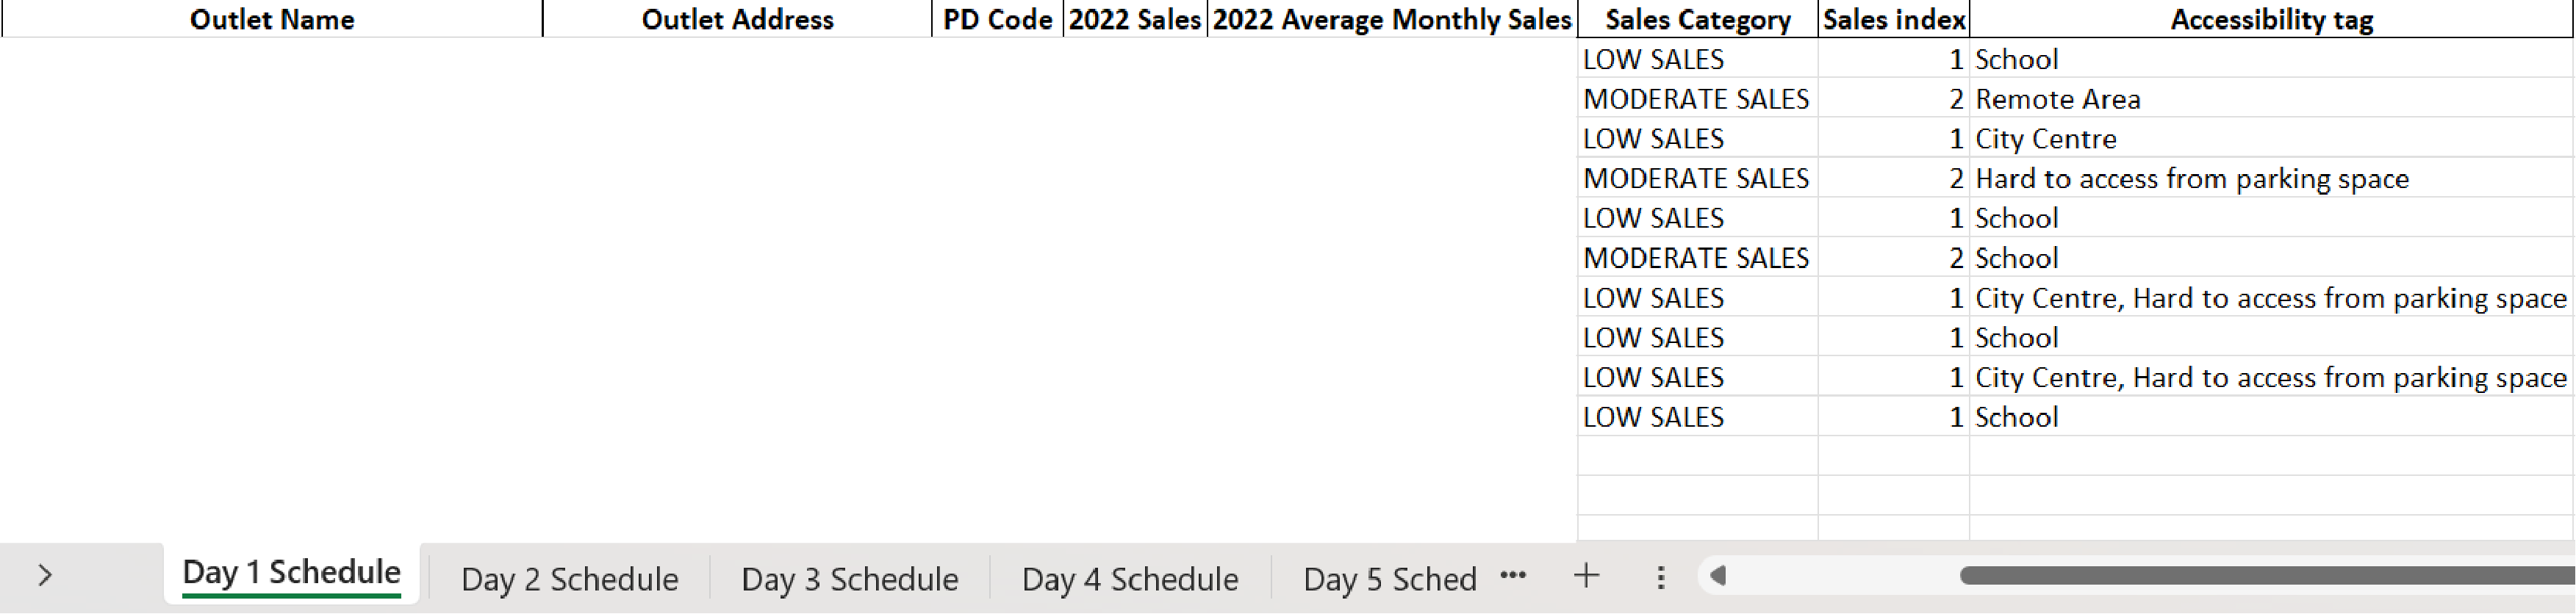

The schedule of all 25 days of the cluster will be written to the same Excel file. 

Note that the schedule generated does **NOT** specify the exact time which each vending machine should be visited. I believe having to include such information in the schedule may be overly restrictive. This is because ervicemen may occasionally have to top up machines which run out faster than planned on an ad-hoc basis. They will then have to make time to visit that machine on a particular day. This would then throw the schedule off if the time to visit each vending machine is strictly stated in the schedule. Instead, the schedule of each day generated is simply **a list of machines the serviceman visits each day**. 

### Analysis of schedules

With the schedules generated, I thought about how the client might be interested to view how changing certain aspects of the schedule might affect operational costs. I have thus also written out some algorithm for them to follow if they choose to conduct such analysis.

This analysis involves looking at the average distance travelled per day for a route, the total distance travelled per month of a route, the fuel costs incurred per year from travelling that average distance and the sales-to-cost ratio.

To conduct this analysis, the longitude and latitude (long/lat) of the location of each vending machine is required. However, the longitude/latitude values are not easily obtainable, particularly for large datasets, as it involves a process known as 'geocoding'. The team I worked with has used a **free** 90 day trial of <a href='https://developers.google.com/maps/documentation/geocoding/overview'>Google Cloud Platform's Geocoding API</a> to geocode all the vending machines to obtain the long/lat values of the vending machines. That is then stored in an Excel file.

With the long/lat values, I could then utilise another Google Cloud service that is the<a href='https://developers.google.com/maps/documentation/javascript/distancematrix'>Google Distance Matrix API</a> to find the distance between any two vending machines.

I sourced from the Internet how to have the API calculate the distance between two coordinates input as arguments.

In [ ]:
import googlemaps

# Set up Google Maps API client
# Replace 'YOUR_API_KEY' with the API key
gmaps = googlemaps.Client(key='YOUR_API_KEY')

# define function to calculate distance in kilometers
def get_driving_distance(start, end):
    directions_result = gmaps.directions(start,
                                         end,
                                         mode="driving",
                                         units="metric")
    return directions_result[0]['legs'][0]['distance']['value'] / 1000.0

To translate distance travelled into fuel cost, the <a href='https://www.motorist.sg/petrol-prices'>cost of each brand of fuel</a> is also researched on. This information is then stored in the same Excel file as the Excel file storing the latitude and longitude values of each vending machine.

In [ ]:
import pandas as pd

# Read the Analysis file with the latlong value and the fuel cost values
latlong_df = pd.read_excel('ScheduleAnalysisInformation.xlsx', sheet_name = "LatLong")
fuelcost_df = pd.read_excel('ScheduleAnalysisInformation.xlsx', sheet_name = "Cost of fuel")

With these information, the analysis of the schedules can then begin. For starters, I have the algorithm read the schedule  of a cluster generated from the scheduling algorithm earlier. A dictionary storing any information on all the clusters that are going to be analysed is also initialised.

In [ ]:
import collections
filename = input("Insert the filename of the schedule of the route created from the schedule creation code," +
                 "WITHOUT the '\.xlsx'\.")

# Initialise a dictionary to store all information on all clusters analysed
all_route_info = collections.defaultdict(dict)

With the information regarding the cluster the client wants to analyse, the total distance travelled per month and the average distance a serviceman travels per day of a cluster can then be found. 

The following code snippet does that by:
 - first getting the total distance travelled in the first day of the schedule in km. 
 - The total distance travelled per month is then calculated by summing those 25 distances. 
 - The average distance travelled in a day is then calculated by dividing that total by 25. 
 - These figures are then stored in the dictionary mentioned earlier.
 - These steps are then repeated for each of the other 24 working days.

In [ ]:
# Initialise dictionary to store the distance of each day's schedule
distances_in_each_days_schedule = {}

# iterate through the schedule for each day
for day in range(1, 26):
    
    df1 = pd.read_excel(filename + '.xlsx', sheet_name = f"Day {day} Schedule")
    
    # Check if there actually are machines scheduled on that day
    if not df1.empty:
    
        # Process the addresses stated in the schedule of that day
        # so that it matches how the address is written in the Excel sheet with the latitude and longitude values
        df1['Full Address'] = list(range(0, len(df1.index)))
        for index, row in df1.iterrows():
            df1.loc[index, 'Full Address'] = df1.loc[index, 'Outlet Address'] + ', SG, ' + str(df1.loc[index, 'PD Code'])

        # Merge the two sheets together based on common addresses
        merged_df = pd.merge(df1, latlong_df, on='Full Address')

        # Initialise another list to record distances between two addresses on the schedule of that day
        distance_between_points_inthatdaysschedule = []

        # Find the driving distance between one point and the next point in the schedule of that day
        for index in range(0, len(merged_df.index) - 1):
            origin_coordinate = (merged_df.loc[index, 'lat'], merged_df.loc[index, 'lon'])
            destination_coordinate = (merged_df.loc[index + 1, 'lat'], merged_df.loc[index + 1, 'lon'])
            distance = get_driving_distance(origin_coordinate, destination_coordinate)
            distance_between_points_inthatdaysschedule.append(distance)
        
        # Sum up all distances
        total_distance_travelled_on_that_day = sum(distance_between_points_inthatdaysschedule)
        
        # Add that total distance on that day to that dictionary that stores the distance of each day's schedule
        distances_in_each_days_schedule[f"Day {day} total"] = total_distance_travelled_on_that_day
        
distance_travelled_per_month = sum(distances_in_each_days_schedule.values())
average_distance_travelled_per_day = sum(distances_in_each_days_schedule.values())/25

# Add that total distance and the average distance into separate dictionaries that store all the information 
# on that route of interest
# and then add those dictionaries for that route into the dictionary that stores all information on all the clusters analysed
all_route_info[filename]['Distance per month in km'] = round(distance_travelled_per_month, 2)
all_route_info[filename]['Avg distance per day in km'] = round(average_distance_travelled_per_day, 2)

The cost of fuel to travel that average distance can then be found. From researching various websites, we have taken that 1 litre of fuel can travel roughly 10km.

In [ ]:
litre_of_fuel_per_km = 0.1 #You can change this value if the fuel consumption rate per 10km is different from stated here

# get information on fuel cost for travelling that avereage distance
for fuel_type in fuelcost_df['Fuel type']:
    for column_index in range(1, len(fuelcost_df.columns)):
        if isinstance(fuelcost_df.iloc[list(fuelcost_df['Fuel type']).index(fuel_type),column_index], float) 
        or isinstance(fuelcost_df.iloc[list(fuelcost_df['Fuel type']).index(fuel_type),column_index], int):
            fuel_cost_p_yr = all_route_info[filename]['Avg distance per day in km'] * litre_of_fuel_per_km * 
            fuelcost_df.iloc[list(fuelcost_df['Fuel type']).index(fuel_type),column_index] * 365
            # store information into dictionary
            all_route_info[filename][f"{fuel_type} {fuelcost_df.columns[column_index]} cost per yr"] = round(fuel_cost_p_yr, 2)

The sales-to-cost ratio of travelling the distance of the cluster can also be calculated. This ratio is calculated based on a linear relationship between distance travelled by a serviceman and the operational cost that will be incurred. This relationship is discovered through the statistical method of **multiple linear regression**.

In [ ]:
# get sales-to-cost ratio of travelling that total distance
sales_to_cost_ratio = 216.75546 - 0.267624*all_route_info[filename]['Distance per month in km']
all_route_info[filename]['Sales-to-cost ratio'] = round(sales_to_cost_ratio, 2)

By now, the Python dictionary would already have distance, fuel cost and sales-to-cost ratio information on ONE cluster. 

To get the information on the schedule of another cluster/other cluster(s) or a variation(s) of the same schedule to compare against, each of the schedules corresponding to that cluster or each of those cluster(s) would need to be put through the analysis code again. After which, the dictionary will have the information on all the clusters that are going to be analaysed.

The information from the analysis can then be displayed in a table. The output contains sensitive information so it will only be partially shown here.

In [ ]:
# Display the analysis results

data = all_route_info
analysis_dataframe = pd.DataFrame.from_dict(data, orient='index').transpose()
print(analysis_dataframe)

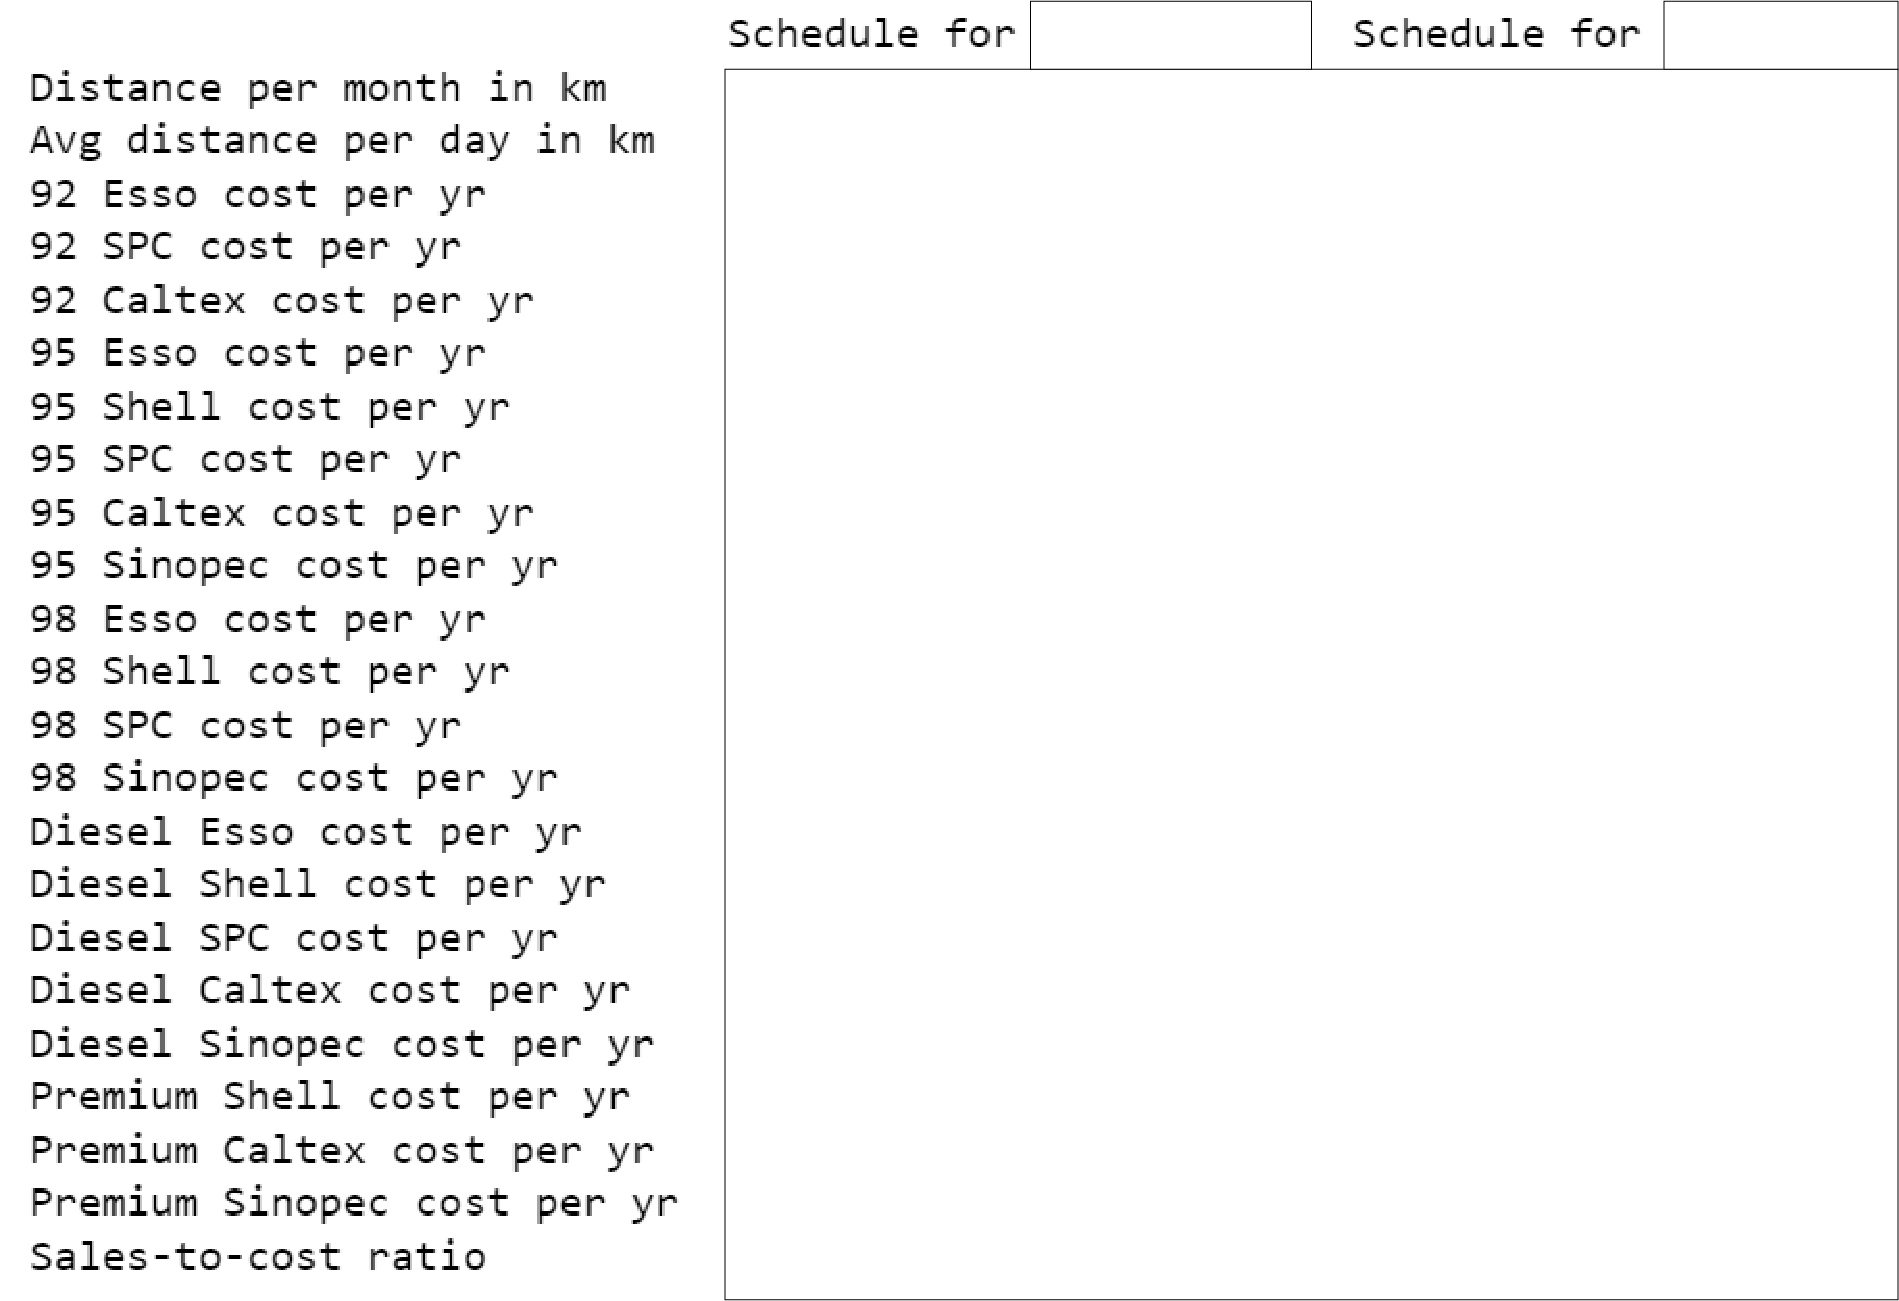

In the above example, a current cluster is compared with that same route with proposed changes in terms of more machines added.

Using the same method, the client could also compare the operational cost of visiting the vending machines at another frequency. The schedules generated using the algorithm earlier takes that high sales, moderate sales and low sales vending machines are visited 8, 4 and 2 times respectively. The client could feed in such a schedule into the analysis algorithm and then another schedule for the same route generated with another frequency (such as 8, 4 and 4) and compare the operational cost. The frequency of visits can be tweaked by changing the values of high_freq, mod_freq and low_freq in the scheduling algorithm.

Comparing the effects of other changes such as visiting all the machines of the same types of locations are also possible.

### Evaluation

Overall, from this project, I have managed to create a data-driven tool that can reduce the amount of effort and time the company spends on operational planning. 

The algorithm does have room for improvement. For instance, the frequency of the visit for a vending machine may not be evenly spaced out within each week. (e.g. In the schedule, a high-sales vending machine which takes more time to be topped up may be visited on a certain day, but then that same vending machine may be visited the next day within that week.)

The scheduling additionally does not take into account any seasonal traffic conditions (e.g. traffic around schools are lower during school holidays) which could hinder the most optimal schedule from being reached.

Despite so, taking on this industry-attached project has truly been a fulfilling experience. I have learnt how to utilise a couple of softwares I have never touched before, Python PuLP and Google Maps API. I also picked up the need to further think about how algorithms I create can further provide value. In this case, I further asked how the algorithm can be more useful for the company from a business point of view. That inspired me to write another algorithm to analyse variations of the same schedule, thereby improving the usefulness of the scheduling algorithm.